# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Третья лабораторная работа </center>
# <center> Фильтры </center>
В данной работе вы познакомитесь с понятием фильтра в цифровой обработке сигналов.

In [1]:
!git clone --recurse-submodules https://github.com/Maunberg/dsp.git

Cloning into 'dsp'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 34 (delta 5), reused 9 (delta 1), pack-reused 8 (from 1)
Unpacking objects: 100% (34/34), 62.87 MiB | 10.25 MiB/s, done.
Submodule 'first_part/dsp_labs_book' (https://github.com/itmo-mbss-lab/dsp_labs_book.git) registered for path 'first_part/dsp_labs_book'
Cloning into '/kaggle/working/dsp/first_part/dsp_labs_book'...
remote: Enumerating objects: 54, done.        
remote: Counting objects: 100% (14/14), done.        
remote: Compressing objects: 100% (4/4), done.        
remote: Total 54 (delta 10), reused 10 (delta 10), pack-reused 40 (from 1)        
Submodule path 'first_part/dsp_labs_book': checked out 'a932c32c8fbb2adef7969cfae8f43ae1aa758d78'


## Важные функции

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.fft
import librosa
import IPython.display as ipd
import librosa.display

# Запретим numpy выполнять деление на 0
np.seterr(divide='raise', invalid='raise')
%matplotlib inline

In [2]:
# from Lab2
def get_magnitude_from_spec(spec):
    return np.abs(spec)
    
    
    raise NotImplementedError()


def get_phi_from_spec(spec):
    return np.angle(spec)
    

    raise NotImplementedError()


# Функция отрисовки аудио сигнала. 
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveplot(wav, sr=sr)
    plt.show()

# Функция отрисовки спектра
def draw_spec(spec, name=None, draw_A=True, draw_p=True, figsize=(14, 3)):
    if len(spec)<100:
        # Рисуем точки как "леденцы на палочках"
        draw_func = plt.stem
    else:
        # При большом N "леденцы" выглядят плохо, 
        # Поэтому будем рисовать огибающую функцию
        draw_func = plt.plot
    
    if draw_A:
        plt.figure(figsize=figsize)
        plt.title("Magnitude spectrum")
        spec_A = get_magnitude_from_spec(spec)
        draw_func(spec_A)
        plt.ylabel("Magnitude")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
        
    if draw_p:
        plt.figure(figsize=figsize)
        plt.title("Phase spectrum")
        phi = get_phi_from_spec(spec)
        draw_func(phi)
        plt.ylabel("Radian")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
    return 


----------------------------------------------
## Теория
Цифровой фильтр \([wiki](https://ru.wikipedia.org/wiki/Цифровой_фильтр)\) —  любой фильтр, обрабатывающий цифровой сигнал с целью выделения и/или подавления определённых частот этого сигнала.
Цифровые фильтры применяются практическе везде, где требуется обработка цифровых сигналов (при работе со звуком, картинками, видео и т.д.)

Основными характеристиками стационарных линейных дискретных фильтров являются:

* Импульсная характеристика 
* Переходная характеристика
* Амплитудно-частотная характеристика
* Фазо-частотная характеристика

**Импульсной характеристикой фильтра** называется его реакция на единичный импульс при нулевых начальных условиях. 

**Переходной характеристикой фильтра** называется его реакция на воздействие в форме единичной функции. 

**Амплитудно-частотной характеристикой фильтра (АЧХ)** называется зависимость амплитуды установившихся колебаний выходного сигнала от частоты её входного гармонического сигнала. Другими словами, АЧХ показывает, как влияет фильтр на амплитуду разных частот входного сигнала. 

**Фазо-частотной характеристикой фильтра (ФЧХ)** называется зависимость фазы установившихся колебаний выходного сигнала от частоты её входного гармонического сигнала. Аналогична АЧХ, только показывает влияние на фазу сигнала.

В данной работе мы будем рассматривать два линейных инвариантных к сдвигу фильтра: фильтр с конечной импульсной характеристикой (КИХ-фильтр) и фильтр с бесконечной импульсной характеристикой (БИХ-фильтр).
### КИХ-фильтры
Определение с [вики](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D0%BB%D1%8C%D1%82%D1%80_%D1%81_%D0%BA%D0%BE%D0%BD%D0%B5%D1%87%D0%BD%D0%BE%D0%B9_%D0%B8%D0%BC%D0%BF%D1%83%D0%BB%D1%8C%D1%81%D0%BD%D0%BE%D0%B9_%D1%85%D0%B0%D1%80%D0%B0%D0%BA%D1%82%D0%B5%D1%80%D0%B8%D1%81%D1%82%D0%B8%D0%BA%D0%BE%D0%B9) :
> Фильтр с конечной импульсной характеристикой (Нерекурсивный фильтр, КИХ-фильтр) или FIR-фильтр (FIR сокр. от finite impulse response — конечная импульсная характеристика) — один из видов линейных цифровых фильтров, характерной особенностью которого является ограниченность по времени его импульсной характеристики (с какого-то момента времени она становится точно равной нулю). Такой фильтр называют ещё нерекурсивным из-за отсутствия обратной связи. Знаменатель передаточной функции такого фильтра — константа.

<!-- ![resources/fir.png](resources/fir.png) -->


### БИХ-фильтры
Определение с [вики](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D0%BB%D1%8C%D1%82%D1%80_%D1%81_%D0%B1%D0%B5%D1%81%D0%BA%D0%BE%D0%BD%D0%B5%D1%87%D0%BD%D0%BE%D0%B9_%D0%B8%D0%BC%D0%BF%D1%83%D0%BB%D1%8C%D1%81%D0%BD%D0%BE%D0%B9_%D1%85%D0%B0%D1%80%D0%B0%D0%BA%D1%82%D0%B5%D1%80%D0%B8%D1%81%D1%82%D0%B8%D0%BA%D0%BE%D0%B9) :
> Фильтр с бесконечной импульсной характеристикой (Рекурсивный фильтр, БИХ-фильтр) или IIR-фильтр (IIR сокр. от infinite impulse response — бесконечная импульсная характеристика) — линейный электронный фильтр, использующий один или более своих выходов в качестве входа, то есть образующий обратную связь. Основным свойством таких фильтров является то, что их импульсная переходная характеристика имеет бесконечную длину во временной области, а передаточная функция имеет дробно-рациональный вид. Такие фильтры могут быть как аналоговыми, так и цифровыми.

<!-- ![resources/iir.png](resources/iir.png) -->

----------------------------

# Задание 1 (2 балла)
Реализуйте КИХ-фильтр и БИХ-фильтр

In [3]:
# Определяем фильтры
def FIR_filter(x, alpha_prev=0.5, alpha_curr=0.5):
    # alpha_prev - weight for previous frame
    # alpha_curr - weight for current frame

    y = [0] * len(x)
    
    y[0] = alpha_curr * x[0]
    
    for i in range(1, len(x)):
        y[i] = alpha_prev * x[i - 1] + alpha_curr * x[i]
    
    return np.array(y)
       

    raise NotImplementedError()

def IIR_filter(x, alpha=0.5):
    # alpha - weight for reccurent connection
    
    y = [0] * len(x)
    
    y[0] = x[0]
    
    for i in range(1, len(x)):
        y[i] = alpha * y[i - 1] + x[i]
    
    return np.array(y)


In [28]:
def test_filters():
    x = np.ones(10)
    y = FIR_filter(x)
    assert y[0] == 0.5 and (y[1:] == 1).all(), \
        RuntimeError(f"bad FIR. x={x}. y={y}")
    y = FIR_filter(x, alpha_prev=0.1, alpha_curr=0.9)
    assert y[0] == 0.9 and (y[1:] == 1).all(), \
        RuntimeError(f"bad FIR(alphas 0.1 and 0.9). x={x}. y={y}")
    y = IIR_filter(x)
    assert y[0]==1 and (y[3:].round() == 2).all() and (y<2).all(), \
        RuntimeError(f"Bad IIR. x={x}. y={y}")
    y = IIR_filter(x, 0.2)
    assert y[0]==1 and (y[3:].round(2) ==1.25).all() and (y<1.25).all(), \
        RuntimeError(f"Bad IIR(alpha={0.2}. x={x}. y={y}")
    print("All Ok!")

test_filters()

All Ok!


# Импульсная и переходная характеристики
# Задание 2 (1 балл)
<!-- Определите единичный импульс длиной 20 отсчетов (переменная impulse). <br>
Получите импульсную характеристику фильтров. -->

## Определите единичный импульс длиной 20 отсчетов (переменная impulse).

In [29]:
## YOUR CODE HERE
impulse = np.array([1] + [0] * 19)
impulse

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Получите импульсную характеристику фильтров (переменные FIR_filter и IIR_filter)

In [30]:
print("Импульсная характеристика фильтров с aplha=0.5:")

# YOUR CODE HERE

fir_impulse_response = FIR_filter(impulse)
iir_impulse_response = IIR_filter(impulse)

Импульсная характеристика фильтров с aplha=0.5:


Построим графики:

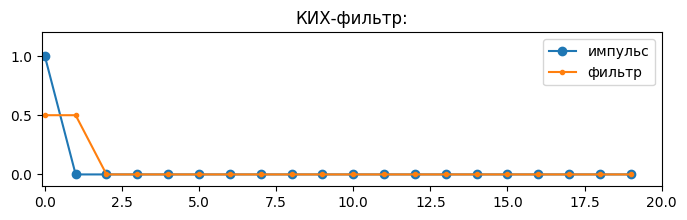

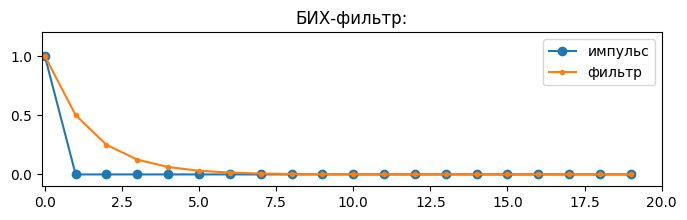

In [31]:
plt.figure(figsize=(8,2))
plt.title("КИХ-фильтр:")
plt.plot(impulse, 'o-')
plt.plot(fir_impulse_response, '.-')
plt.legend(['импульс', 'фильтр'])
plt.axis([-0.1, len(impulse), -0.1, 1.2])
plt.show()

plt.figure(figsize=(8,2))
plt.title("БИХ-фильтр:")
plt.plot(impulse, 'o-')
plt.plot(iir_impulse_response, '.-')
plt.legend(['импульс', 'фильтр'])
plt.axis([-0.1, len(impulse), -0.1, 1.2])
plt.show()

In [32]:
assert impulse.shape[0] == 20, "Bad impulse shape"
assert (fir_impulse_response[0:2] == 0.5).all() and \
        (fir_impulse_response[2:] == 0).all(), "Bad FIR."
assert iir_impulse_response.sum().round() == 2 and \
        iir_impulse_response.sum() < 2 and \
        (iir_impulse_response != 0).all(), "Bad IIR."
assert iir_impulse_response[1:].sum().round() == 1 and \
        iir_impulse_response[1:].sum()<1 and \
        iir_impulse_response[2:].sum() < 0.5, "Bad IIR."
print("All ok!")

All ok!


# Задание 3 (1 балл)
<!-- Определите единичный скачок длиной 20 отсчетов (переменная step). <br>
Получите переходную характеристику фильтров. -->

## Определите единичный скачок длиной 20 отсчетов (переменная step).

In [33]:
## YOUR CODE HERE
step =np.array([1] * 20)
step

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Получите импульсную характеристику фильтров

In [34]:
print("Переходная характеристика фильтров с alpha=0.5:")
# Получите переходную характеристику фильтров
# YOUR CODE HERE

fir_step_response = FIR_filter(step)
iir_step_response = IIR_filter(step)

Переходная характеристика фильтров с alpha=0.5:


Построим графики:

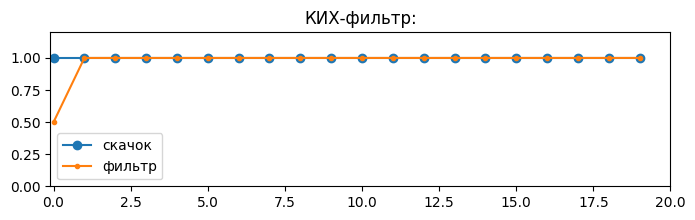

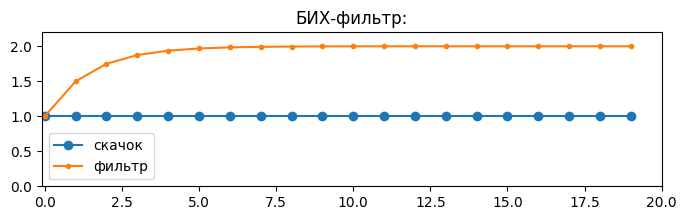

In [35]:
plt.figure(figsize=(8,2))
plt.title("КИХ-фильтр:")
plt.plot(step, 'o-')
plt.plot(fir_step_response, '.-')
plt.axis([-0.1, len(step), 0, 1.2])
plt.legend(['скачок', 'фильтр'])

plt.show()

plt.figure(figsize=(8,2))
plt.title("БИХ-фильтр:")
plt.plot(step, 'o-')
plt.plot(iir_step_response, '.-')
plt.axis([-0.1, len(step), 0, 2.2])
plt.legend(['скачок', 'фильтр'])
plt.show()

In [36]:
assert step.shape[0] == 20, "Bad step shape"
assert fir_step_response[0] == 0.5 and \
        (fir_step_response[1:] == 1).all(), "Bad FIR."
assert iir_step_response[0] == 1 and iir_step_response[1] == 1.5 and iir_step_response[2] == 1.75 and \
        iir_step_response.mean().round() == 2 and (iir_step_response < 2).all(), "Bad IIR."
print("All ok!")

All ok!


# Амплитудно-частотная и фазо-частотная характеристики
# Задание 4 (1 балл)
Получите амплитудно-частотную характеристику фильтров для единичного импульса (переменная impulse).

In [40]:
print("Амплитудно-частотная характеристика фильтров с alpha=0.5")

# Получить амплитудно-частотную характеристику
# YOUR CODE HERE

fir_frequency_response = get_magnitude_from_spec(np.fft.fft(FIR_filter(impulse))[:len(impulse) // 2])
iir_frequency_response = get_magnitude_from_spec(np.fft.fft(IIR_filter(impulse))[:len(impulse) // 2])

Амплитудно-частотная характеристика фильтров с alpha=0.5


Построим графики:

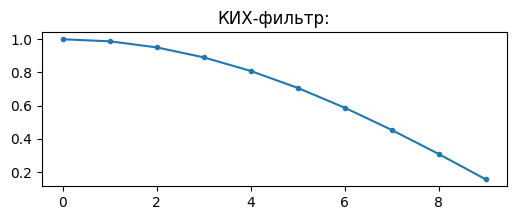

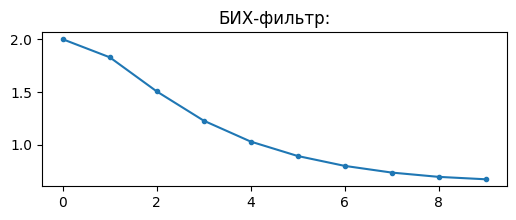

In [41]:
plt.figure(figsize=(6,2))
plt.title("КИХ-фильтр:")
plt.plot(fir_frequency_response, '.-')
plt.show()

plt.figure(figsize=(6,2))
plt.title("БИХ-фильтр:")
plt.plot(iir_frequency_response, '.-')
plt.show()

In [42]:
assert fir_frequency_response.shape[0] == iir_frequency_response.shape[0] == 10, \
    f"Bad FR shape. Must be N//2."
_ideal_fir_fr = np.array([1. , 0.98768834, 0.95105652, 0.89100652, 0.80901699,
       0.70710678, 0.58778525, 0.4539905 , 0.30901699, 0.15643447])
assert np.allclose(fir_frequency_response, _ideal_fir_fr), \
    f"Bad fir FR. diff is {np.abs(fir_frequency_response - _ideal_fir_fr).sum()}"
_ideal_iir_fr = np.array([1.99999809, 1.82896351, 1.50587408, 1.22885364, 1.03088138,
       0.89442634, 0.80089238, 0.73765316, 0.69689865, 0.67403739])
assert np.allclose(iir_frequency_response, _ideal_iir_fr), \
    f"Bad iir FR. diff is {np.abs(iir_frequency_response - _ideal_iir_fr).sum()}"

print("All ok!")

All ok!


# Задание 5 (1 балл)
Получите фазово-частотную характеристику фильтров для единичного импульса (переменная impulse).

In [43]:
print("Фазово-частотная характеристика")

# YOUR CODE HERE

fir_phase_response = get_phi_from_spec(np.fft.fft(FIR_filter(impulse))[:len(impulse) // 2])
iir_phase_response = get_phi_from_spec(np.fft.fft(IIR_filter(impulse))[:len(impulse) // 2])

Фазово-частотная характеристика


Построим графики:

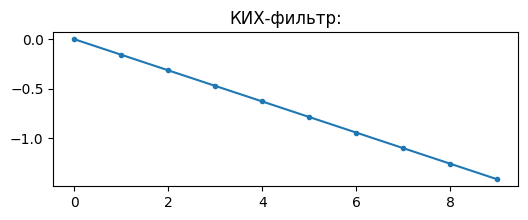

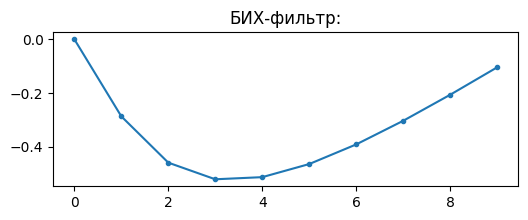

In [44]:
plt.figure(figsize=(6,2))
plt.title("КИХ-фильтр:")
plt.plot(fir_phase_response, '.-')
plt.show()

plt.figure(figsize=(6,2))
plt.title("БИХ-фильтр:")
plt.plot(iir_phase_response, '.-')
plt.show()

In [45]:
assert fir_phase_response.shape[0] == iir_phase_response.shape[0] == 10, \
    f"Bad PR shape. Must be N//2."
_ideal_fir_pr = np.array([-0.        , -0.15707963, -0.31415927, -0.4712389 , -0.62831853,
       -0.78539816, -0.9424778 , -1.09955743, -1.25663706, -1.41371669])
assert np.allclose(fir_phase_response, _ideal_fir_pr), \
    f"Bad fir PR. diff is {np.abs(fir_phase_response - _ideal_fir_pr).sum()}"
_ideal_iir_pr = np.array([-0.        , -0.28649379, -0.45845783, -0.52023287, -0.51233491,
       -0.46364761, -0.39071251, -0.30300249, -0.20627323, -0.10433379])
assert np.allclose(iir_phase_response, _ideal_iir_pr), \
    f"Bad iir PR. diff is {np.abs(iir_phase_response - _ideal_iir_pr).sum()}"

print("All ok!")

All ok!


# Эксперимент по информативности

Цель: Исследовать эффективность извлечения признаков из цифрового сигнала с помощью сравнения качества обученной на этих признаках модели
Задачи:
- загрузить датасет и обработать признаки
- обучить модели
- сравнить модели
- сделать выводы

## Загрузка датасета

In [4]:
from datasets import load_dataset
import soundfile as sf
from tqdm import tqdm
import os

In [5]:
ds = load_dataset("danavery/urbansound8K")

## Изучение датасета

In [19]:
ds['train']

Dataset({
    features: ['audio', 'slice_file_name', 'fsID', 'start', 'end', 'salience', 'fold', 'classID', 'class'],
    num_rows: 8732
})

In [13]:
spectr, sr = ds['train']['audio'][0]['array'], ds['train']['audio'][0]['sampling_rate']

In [57]:
ds['train']['class'][0]

'dog_bark'

In [56]:
ipd.Audio(data=spectr, rate=sr)

### Визуализация сигнала

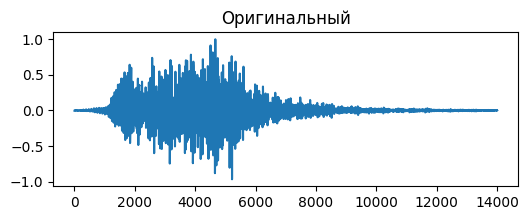

In [62]:
plt.figure(figsize=(6,2))
plt.title("Оригинальный")
plt.plot(spectr)
plt.show()

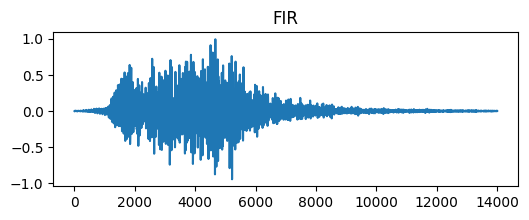

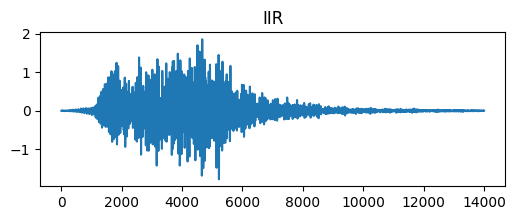

In [77]:
transforms = {
    'FIR':FIR_filter,
    'IIR': IIR_filter,
}


for name in transforms:
    plt.figure(figsize=(6,2))
    plt.title(name)
    plt.plot(transforms[name](spectr))
    plt.show()

### Визуализация оригинальной спектрограммы

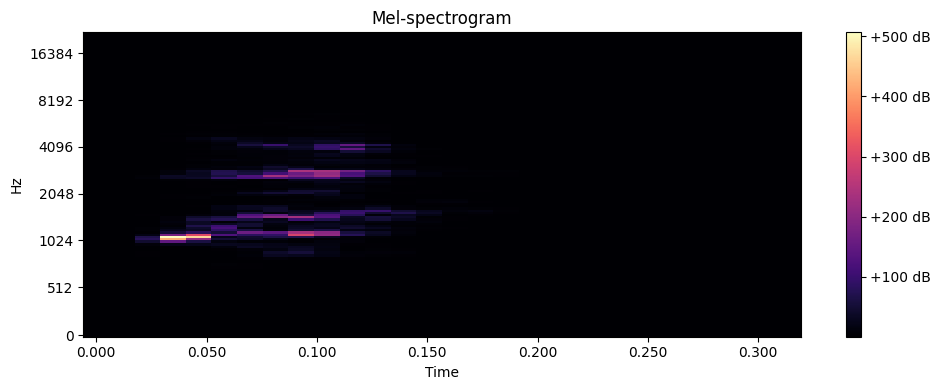

In [14]:
S = librosa.feature.melspectrogram(y=spectr, sr=sr, n_mels=128, fmax=8000)
plt.figure(figsize=(10, 4))
librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-spectrogram')
plt.tight_layout()
plt.show()

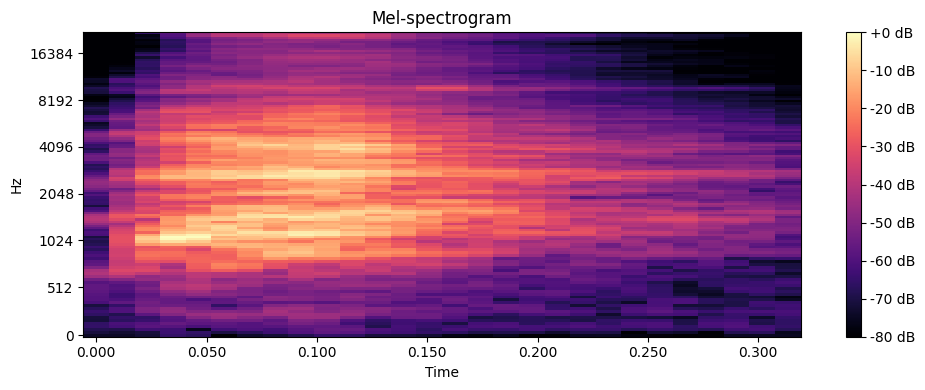

In [15]:
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-spectrogram')
plt.tight_layout()
plt.show()

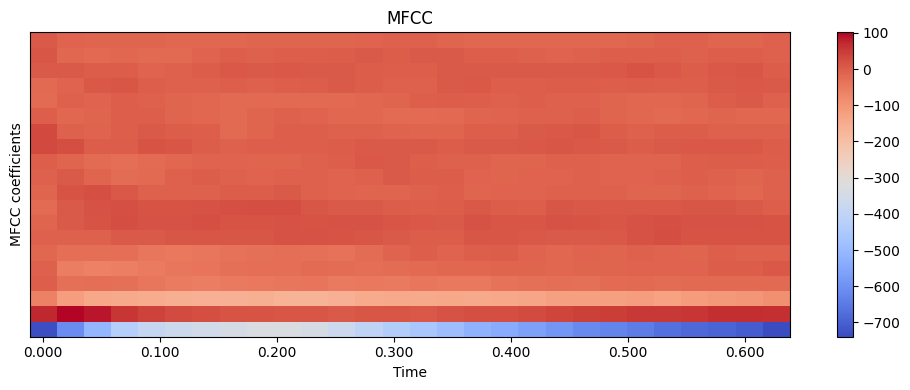

In [16]:
mfccs = librosa.feature.mfcc(S=log_S, n_mfcc=20)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.ylabel('MFCC coefficients')
plt.title('MFCC')
plt.tight_layout()
plt.show()

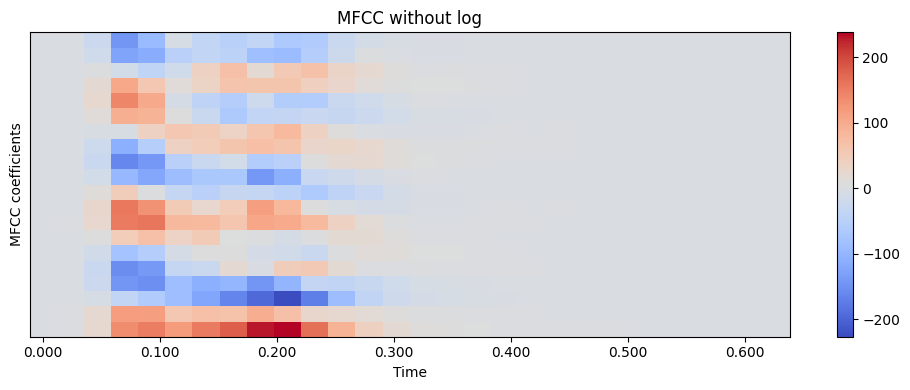

In [18]:
mfccs = librosa.feature.mfcc(S=S, n_mfcc=20)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.ylabel('MFCC coefficients')
plt.title('MFCC without log')
plt.tight_layout()
plt.show()

### Визуализация mel спектрограмм с фильтрами

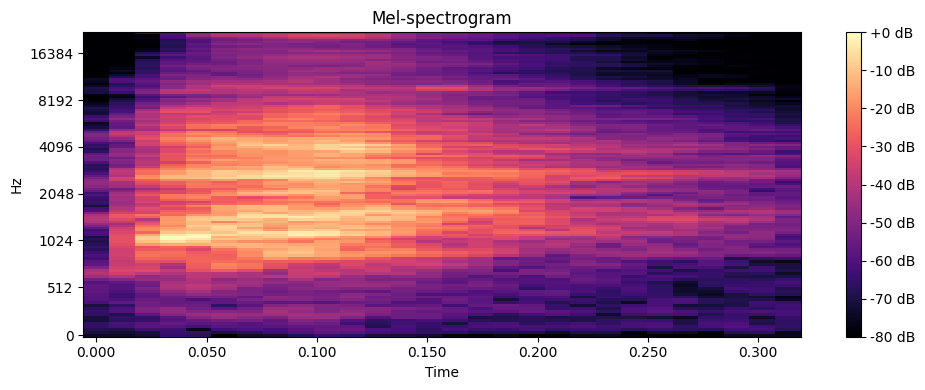

In [44]:
S = librosa.feature.melspectrogram(y=FIR_filter(spectr), sr=sr, n_mels=128, fmax=8000)
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-spectrogram')
plt.tight_layout()
plt.show()

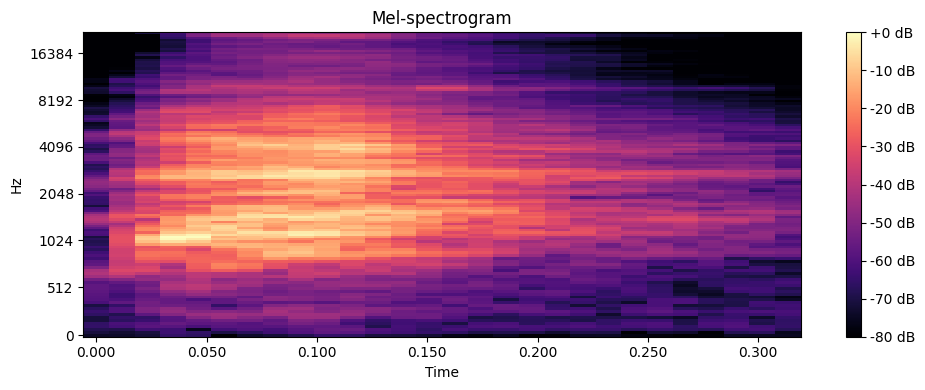

In [45]:
S = librosa.feature.melspectrogram(y=IIR_filter(spectr), sr=sr, n_mels=128, fmax=8000)
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-spectrogram')
plt.tight_layout()
plt.show()

## Создание выборки

In [46]:
IIR_filter(spectr).shape, \
FIR_filter(spectr).shape, \
spectr.shape, \
log_S.flatten().shape

# Для начала я хочу протестировать на бустингах, для этого нужен табличный вид, список значений, поэтому спектрограмму буду разворачивать
# Если будет время, ещё нейронки попробую, где можно свёртки использовать

((14004,), (14004,), (14004,), (3584,))

In [7]:
wav_dir = '/kaggle/working/urbansound8K/'
# os.mkdir(wav_dir)
classes = {}
for i in tqdm(ds['train']):
    wav = wav_dir + i['audio']['path']
    array = i['audio']['array']
    tag = i['class']
    sf.write(wav, array, samplerate=44100)
    classes[wav] = tag

100%|██████████| 8732/8732 [03:21<00:00, 43.31it/s]


In [8]:
list(classes.items())[0]

('/kaggle/working/urbansound8K/100032-3-0-0.wav', 'dog_bark')

In [9]:
features = list(classes.keys())
targets = list(classes.values())

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
targets_le = le.fit_transform(targets)

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class MyPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, mode='original', pad=400_000):
        self.mode = mode
        self.pad = pad
        
    def fit_transform(self, X, y=None):
        return self.transform(X)

    def fit(self, X, y=None):
        return self

    def transform(self, X, to_pad=True):
        if not isinstance(X, list): 
            X = [X]
        processed_data = []
        for x in X:
            x = preprocess_data(way=x, mode=self.mode)
            if to_pad:
                pad_len = self.pad - x.shape[0]
                if pad_len >= 0:
                    x = np.pad(x, (0, pad_len), 'constant', constant_values=(0))
                x = x[:self.pad]
            processed_data.append(x)
        return np.array(processed_data)
    
def preprocess_data(way, mode='original'):
    spectr, sr = librosa.core.load(way)
    if mode == 'original':
        return spectr
    elif mode == 'IIR':
        return IIR_filter(spectr)
    elif mode == 'FIR':
        return FIR_filter(spectr)
    elif mode == 'spectr':
        S = librosa.feature.melspectrogram(y=spectr, sr=sr, n_mels=128, fmax=8000)
        return S.flatten()
    elif mode == 'log_spectr':
        S = librosa.feature.melspectrogram(y=spectr, sr=sr, n_mels=128, fmax=8000)
        log_S = librosa.power_to_db(S, ref=np.max)
        return log_S.flatten()
    elif mode == 'MFCC':
        S = librosa.feature.melspectrogram(y=spectr, sr=sr, n_mels=128, fmax=8000)
        log_S = librosa.power_to_db(S, ref=np.max)
        mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=20)
        return mfcc.flatten()

In [58]:
preproc = MyPreprocessor()
preproc.fit_transform(features[:20]).shape

(20, 400000)

In [61]:
mx = 0
preproc = MyPreprocessor(mode='original')
for i in tqdm(features):
    n = preproc.transform(i, to_pad=False).shape[1]
    if n > mx:
        mx = n
mx
# original = 384000
# IIR = 384000
# FIR = 384000 too long
# spectr = 96128
# log_s = 96128
# mfcc = 15020

100%|██████████| 8732/8732 [00:28<00:00, 305.13it/s]


384000

In [62]:
mx = 0
preproc = MyPreprocessor(mode='IIR')
for i in tqdm(features):
    n = preproc.transform(i, to_pad=False).shape[1]
    if n > mx:
        mx = n
mx

100%|██████████| 8732/8732 [07:25<00:00, 19.62it/s]


384000

In [64]:
mx

192000

In [67]:
mx = 0
preproc = MyPreprocessor(mode='MFCC')
for i in tqdm(features):
    n = preproc.transform(i, to_pad=False).shape[1]
    if n > mx:
        mx = n
mx

100%|██████████| 8732/8732 [02:59<00:00, 48.66it/s]


15020

In [66]:
mx = 0
preproc = MyPreprocessor(mode='log_spectr')
for i in tqdm(features):
    n = preproc.transform(i, to_pad=False).shape[1]
    if n > mx:
        mx = n
mx

100%|██████████| 8732/8732 [02:56<00:00, 49.49it/s]


96128

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier  # Или другой алгоритм бустинга
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [19]:
X_train, X_test, y_train, y_test = train_test_split(features, targets_le, test_size=0.5, random_state=42, stratify=targets_le, shuffle=True)

In [20]:
len(X_train)

4366

## Бустинг

In [21]:
pipeline = Pipeline([
    ('preprocessor', MyPreprocessor()),
    ('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier())
])

In [ ]:
pipeline.fit(X_train, y_train) # обучение очень долгое, поэтому я запустил его сразу в несколько потоков на своей машине, тут уже предоставлю только результаты. 
# Код будет доступен в репо

In [ ]:
y_pred = pipeline.predict(X_test)

<pre>
           Train F1
- original    9k 
- IIR         7k

## Нейронка

In [12]:
import torch
from torch.utils.data import Dataset,  DataLoader

class CustomDataset(Dataset):
    def __init__(self, data, labels, mode='original', pad=400_000):
        self.data = data
        self.labels_orig = labels 
        self.mode = mode
        self.pad = pad
        
        self.labels_translate = {}
        n = 0
        for i in labels:
            if i not in self.labels_translate:
                self.labels_translate[i] = n
                n += 1
        self.labels = torch.tensor([self.labels_translate[i] for i in self.labels_orig])

    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        label_item = self.labels[idx]
        
        data_item = self.data[idx]
        data_item =  torch.from_numpy(self.preprocess_data(data_item, mode=self.mode))
        pad_len = self.pad - data_item.shape[0]
        padded_data = torch.nn.functional.pad(data_item, (0, pad_len), "constant", 0)
        return padded_data, label_item
    
    def preprocess_data(self, way, mode='original'):
        spectr, sr = librosa.core.load(way)
        if mode == 'original':
            return spectr
        elif mode == 'IIR':
            return IIR_filter(spectr)
        elif mode == 'FIR':
            return FIR_filter(spectr)
        elif mode == 'spectr':
            S = librosa.feature.melspectrogram(y=spectr, sr=sr, n_mels=128, fmax=8000)
            return S.flatten()
        elif mode == 'log_spectr':
            S = librosa.feature.melspectrogram(y=spectr, sr=sr, n_mels=128, fmax=8000)
            log_S = librosa.power_to_db(S, ref=np.max)
            return log_S.flatten()
        elif mode == 'MFCC':
            S = librosa.feature.melspectrogram(y=spectr, sr=sr, n_mels=128, fmax=8000)
            log_S = librosa.power_to_db(S, ref=np.max)
            mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=20)
            return mfcc.flatten()

In [48]:
torch.tensor([1, 2, 3])

tensor([1, 2, 3])

In [178]:
mode = 'IIR'
dataset_train = CustomDataset(features[:-2000], targets[:-2000], mode=mode)
dataloader_train = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

dataset_valid = CustomDataset(features[-2000:], targets[-2000:], mode=mode)
dataloader_valid = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

In [73]:
for i in dataloader:
    break

In [179]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import pytorch_lightning as pl
from pytorch_lightning import Trainer

In [189]:
from sklearn.metrics import accuracy_score


class CNNClassifier(pl.LightningModule):
    def __init__(self, num_classes=10, learning_rate=1e-3):
        super(CNNClassifier, self).__init__()
        self.save_hyperparameters()
        
        # Сверточные слои
        self.conv1 = torch.nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=2)
        self.conv2 = torch.nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=2)
#         self.conv3 = torch.nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=2)
        
        # Полносвязные слои
        self.fc1 = torch.nn.Linear(400_000, 100_000)
        self.fc2 = torch.nn.Linear(100_000, 20_000)
        self.fc3 = torch.nn.Linear(20_000, 10_000)
        self.fc4 = torch.nn.Linear(10_000, 1_000)
        self.fc5 = torch.nn.Linear(1_000, 512)
        self.fc6 = torch.nn.Linear(512, num_classes)
        
        # Параметр обучения
        self.learning_rate = learning_rate

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        _, predicted = torch.max(y_hat, 1)
        Acc = accuracy_score(y.cpu().numpy(), predicted.cpu().numpy())
        self.log('Acc', Acc, prog_bar=True)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        _, predicted = torch.max(y_hat, 1)
        Acc = accuracy_score(y.cpu().numpy(), predicted.cpu().numpy())
        self.log('Acc', Acc, prog_bar=True)
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [ ]:
model = CNNClassifier()

In [ ]:
trainer = Trainer(max_epochs=10, accelerator="auto")

In [187]:
trainer.fit(model, dataloader_train, dataloader_valid)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

NameError: name 'exit' is not defined

In [173]:
trainer.validate(model, dataloader_valid)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    2.2563529014587402     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 2.2563529014587402}]

In [ ]:
[{'val_loss': 2.2563529014587402}]